In [1]:
import yaml
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from data import Data, SeqBPRDataset

In [26]:
with open("config.yaml", 'r', encoding='utf-8') as f:
    args = yaml.unsafe_load(f)
data = Data(args['data'])
args

>>>> 数据加载完成: 2536880 条交互, 1411 个用户, 3325 个物品


{'base_path': '/Users/horiki/Code/graduation_design/',
 'data': {'maxlen': 20,
  'is_sample': False,
  'base_model_topk': 100,
  'device': 'cpu',
  'name': 'KuaiRec',
  'MovieLens-1M': {'sep': '::',
   'n_item': 3952,
   'train_test_split': 0.99,
   'num_negatives': 1,
   'user_threshold': 10,
   'item_threshold': 10,
   'rating_threshold': 2},
  'KuaiRec': {'sep': ',',
   'n_item': 10727,
   'train_test_split': 0.99,
   'num_negatives': 1,
   'user_threshold': 0,
   'item_threshold': 0,
   'rating_threshold': 0},
  'Amazon': {'sep': ',',
   'n_item': 27907,
   'train_test_split': 0.9,
   'num_negatives': 2,
   'user_threshold': 0,
   'item_threshold': 0,
   'rating_threshold': 0},
  'item_path': '/Users/horiki/Code/graduation_design/data/KuaiRec/item.csv',
  'path': '/Users/horiki/Code/graduation_design/data/KuaiRec/interaction.csv',
  'item_emb_path': '/Users/horiki/Code/graduation_design/llm_emb/KuaiRec/bert_emb64.npy',
  'base_model': ['acf', 'fdsa', 'harnn', 'caser', 'pfmc', 'sasr

In [73]:
np.save(f'datasets/{args["data"]["name"]}/train_samples.npy', data.train_samples)
np.save(f'datasets/{args["data"]["name"]}/test_samples.npy', data.test_samples)

In [27]:
train_samples = np.load(f'datasets/{args["data"]["name"]}/train_samples.npy', allow_pickle=True)
test_samples = np.load(f'datasets/{args["data"]["name"]}/test_samples.npy', allow_pickle=True)
train_dataset = SeqBPRDataset(train_samples, args['data']['device'])
test_dataset = SeqBPRDataset(test_samples, args['data']['device'], is_test=True)
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

## 评估指标

In [13]:
def nDCG(rec_items, test_set):
    DCG = lambda x: np.sum(x / np.log(np.arange(2, len(x) + 2)))
    def get_implict_matrix(rec_items, test_set):
        rel_matrix = [[0] * rec_items.shape[1] for _ in range(rec_items.shape[0])]
        for user in range(len(test_set)):
            for index, item in enumerate(rec_items[user]):
                if item in test_set[user]:
                    rel_matrix[user][index] = 1
        return np.array(rel_matrix)
    rel_matrix = get_implict_matrix(rec_items, test_set)
    ndcgs = []
    for user in range(len(test_set)):
        rels = rel_matrix[user]
        dcg = DCG(rels)
        idcg = DCG(sorted(rels, reverse=True))
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcgs.append(ndcg)
    return ndcgs

def map(recommended_items, interacted_items):
    interacted_set = set(interacted_items)

    hits, precisions = [], []
    relevant_count = 0
    for i, item in enumerate(recommended_items):
        position = i + 1  # 位置从1开始计数

        is_relevant = item in interacted_set
        hits.append(1 if is_relevant else 0)
        if is_relevant:
            relevant_count += 1
            precision_at_k = relevant_count / position
            precisions.append(precision_at_k)

    if not precisions:
        return 0.0
    return sum(precisions) / len(precisions)

def mrr(results, relevant_docs):
    relevant_set = set(relevant_docs)
    rank = 0
    for i, doc_id in enumerate(results):
        if doc_id in relevant_set:
            rank = i + 1  # 排名从1开始
            break
    if rank > 0:
        reciprocal_rank = 1.0 / rank
        return reciprocal_rank
    else:
        return 0.0

def infer(model, topk):
    with torch.no_grad():
        ndcgs, maps, mrrs = [], [], []
        for batch in tqdm(test_loader, desc="计算测试集指标"):
            
            all_scores = model(batch, is_test=True)
            scores, indices = torch.topk(all_scores, topk)

            for i in range(len(batch['user_id'])):
                user_id = batch['user_id'][i].item()
                pos_item = batch['pos_item'][i].item()

                true_item_ids = data.user_interacted_item_ids[user_id]
                true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

                predicted_item_ids = np.array([indices[i].cpu().numpy().tolist()])
                maps.append(map(predicted_item_ids[0], true_item_ids))
                ndcgs.append(nDCG(np.array(predicted_item_ids), [true_item_ids]))
                mrrs.append(mrr(predicted_item_ids[0], true_item_ids))
    return {'ndcg': np.mean(ndcgs), 'map': np.mean(maps), 'mrr': np.mean(mrrs)}

## EnsRec

In [29]:
from model.pre_ensrec import EnsRec
ensrec = EnsRec(args['model'], args['data'], data.n_user)
ensrec.load_state_dict(torch.load(f"ckpt/{args['data']['name']}/pre_ensrec_0.463.pth", map_location=torch.device('cpu')), strict=False)
ensrec.eval()

>>>> 加载预计算的物品嵌入...


EnsRec(
  (dien): DIEN(
    (gru_cell): GRUCell(64, 64)
    (attention): AttentionLayer(
      (q_proj): Linear(in_features=64, out_features=64, bias=True)
      (k_proj): Linear(in_features=64, out_features=64, bias=True)
      (v_proj): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (augru_cell): GRUCell(128, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (user_embeddings): Embedding(1411, 64)
  (item_tower): ItemTower(
    (item_transform): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (preference_alignment): PreferenceAlignmentModule(
      (content_adaptor): Linear(in_features=64, out_features=64, bias=True)
      (position_embeddings): Embedding(20, 64)
      (transformer_layers): ModuleList(
        (0-3): 4 x TransformerBloc

In [11]:
from model.ensrec import EnsRec
ensrec = EnsRec(args['model'], args['data'], data.n_user, args['data'][args['data']['name']]['n_item'])
ensrec.load_state_dict(torch.load("ckpt/MovieLens-1M/ensrec_0.4518.pth", map_location=torch.device('cpu')), strict=False)
ensrec.eval()

EnsRec(
  (dien): DIEN(
    (gru_cell): GRUCell(64, 64)
    (attention): AttentionLayer(
      (q_proj): Linear(in_features=64, out_features=64, bias=True)
      (k_proj): Linear(in_features=64, out_features=64, bias=True)
      (v_proj): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (augru_cell): GRUCell(128, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (user_embeddings): Embedding(6033, 64)
  (item_embeddings): Embedding(3953, 64)
)

In [14]:
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)
infer(ensrec, 10)

计算测试集指标: 100%|██████████| 17/17 [00:01<00:00, 11.45it/s]


{'ndcg': np.float64(0.45177223071673256),
 'map': np.float64(0.321911322013882),
 'mrr': np.float64(0.35940901785119883)}

## 集成权重可视化

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [30]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

wgts = []
with torch.no_grad():
    metrics = []
    for i, batch in enumerate(test_loader):
        user_emb = ensrec.user_embeddings(batch['user_id'])  # bc, dim
        user_interaction = ensrec.item_tower(batch['user_seq'], 'user_seq')  # bc, seq_len, dim
        target_emb = ensrec.item_tower(batch['pos_item'], 'single_item')  # bc, dim
        preference = ensrec.dien(user_interaction, target_emb) + user_emb  # bc, dim

        batch_size, n_base_model, seq_len = batch['base_model_preds'].shape
        item_ids_np = batch['base_model_preds'].cpu().numpy()
        item_ids_flat = item_ids_np.reshape(-1)
        item_ids_mapped = np.array([ensrec.item_tower.item_to_idx[str(id)] for id in item_ids_flat])
        item_indices = torch.tensor(item_ids_mapped, device=batch['base_model_preds'].device)
        item_embeddings = ensrec.item_tower.item_embeddings[item_indices]
        item_embeddings = item_embeddings.reshape(batch_size, n_base_model, seq_len, -1)
        basemodel_emb = ensrec.llm_projection(item_embeddings)  # bc, n_base_model, seq_len, dim
        # base_model_focus_llm = ensrec.item_tower(batch['base_model_preds'], 'base_model')  # bc, n_base_model, seq_len, dim

        # 时间衰减权重
        time_weights = 1.0 / torch.log2(torch.arange(ensrec.seq_max_len, device=ensrec.device) + 2)
        time_weights = time_weights.view(1, 1, -1, 1)
        basemodel_emb = torch.sum(time_weights * basemodel_emb, dim=2)  # [bc, n_base_model, dim]

        # 计算基模型权重
        # [bc, n_base_model, dim] @ [bc, 1, dim] -> [bc, n_base_model, 1]
        preference = preference.unsqueeze(1).transpose(-2, -1)  # [bc, dim, 1]
        wgts_org = torch.matmul(basemodel_emb, preference).squeeze(-1)  # [bc, n_base_model]

        wgts.append(torch.nn.functional.softmax(wgts_org, dim=-1).squeeze(0).cpu())
        if (i + 1) % 50 == 0:
            break

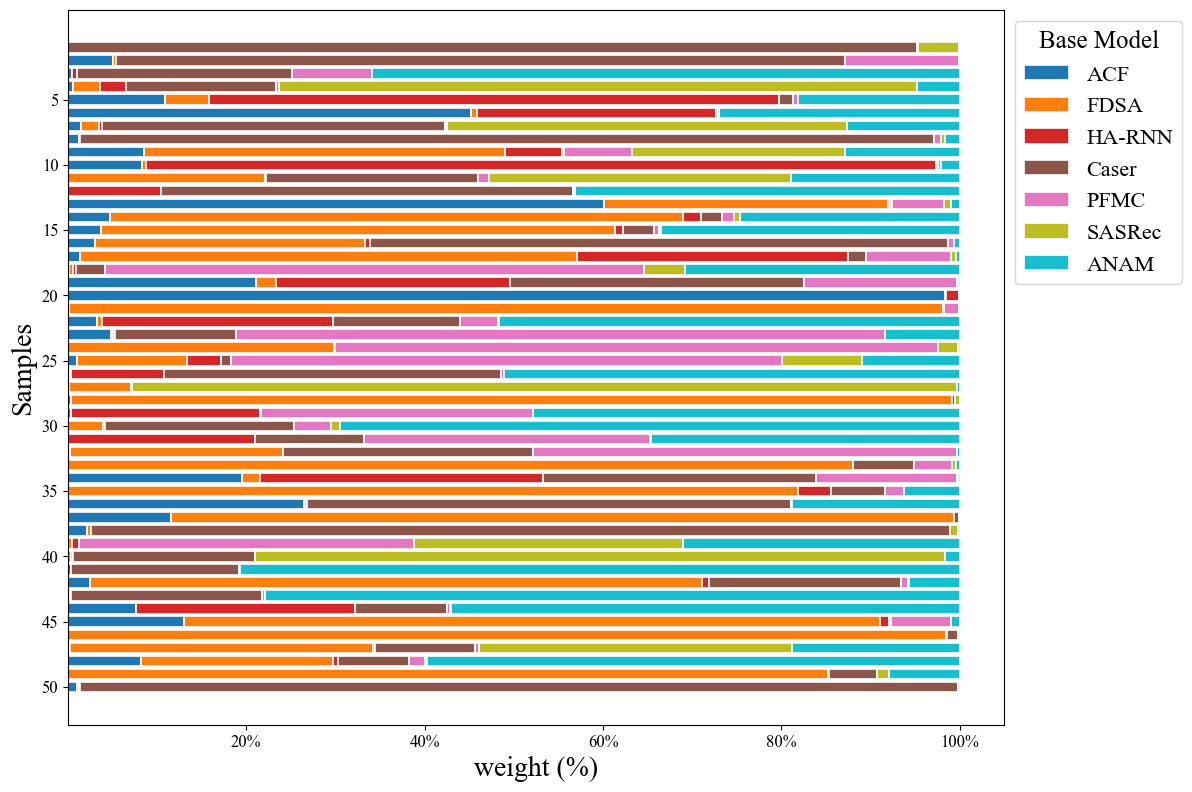

In [34]:
import matplotlib.pyplot as plt
import numpy as np

weights = wgts

# 模型名称
models = ['ACF', 'FDSA', 'HA-RNN', 'Caser', 'PFMC', 'SASRec', 'ANAM']

# 时间周期，从上到下索引
categories = [f'{len(weights) - i}' for i in range(len(weights))]

# 将 weights 转换为 NumPy 数组
weights_np = np.array([w.numpy() for w in weights])

# 定义颜色（使用对比更明显的颜色映射）
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))  # 使用 tab10 颜色映射

# 绘制堆叠条形图
fig, ax = plt.subplots(figsize=(12, 8))  # 调整图表大小，减少高度和宽度
y = np.arange(len(categories))  # 纵轴位置
left = np.zeros(len(categories))  # 初始化左侧位置

for i, model in enumerate(models):
    ax.barh(y, weights_np[:, i], left=left, label=model, color=colors[i], edgecolor='white', linewidth=1.2)
    left += weights_np[:, i]  # 更新左侧位置

# 添加标题和标签
ax.set_ylabel('Samples', fontsize=20)  # 调整字体大小
ax.set_xlabel('weight (%)', fontsize=20)

# 设置纵坐标隔 5 个显示一个
ax.set_yticks(y[::5])
ax.set_yticklabels(categories[::5], fontsize=12)  # 调整字体大小

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
ax.tick_params(axis='x', labelsize=12)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Base Model', title_fontsize=18, fontsize=16)

plt.tight_layout(pad=1.0)  # 调整布局紧凑程度
plt.show()

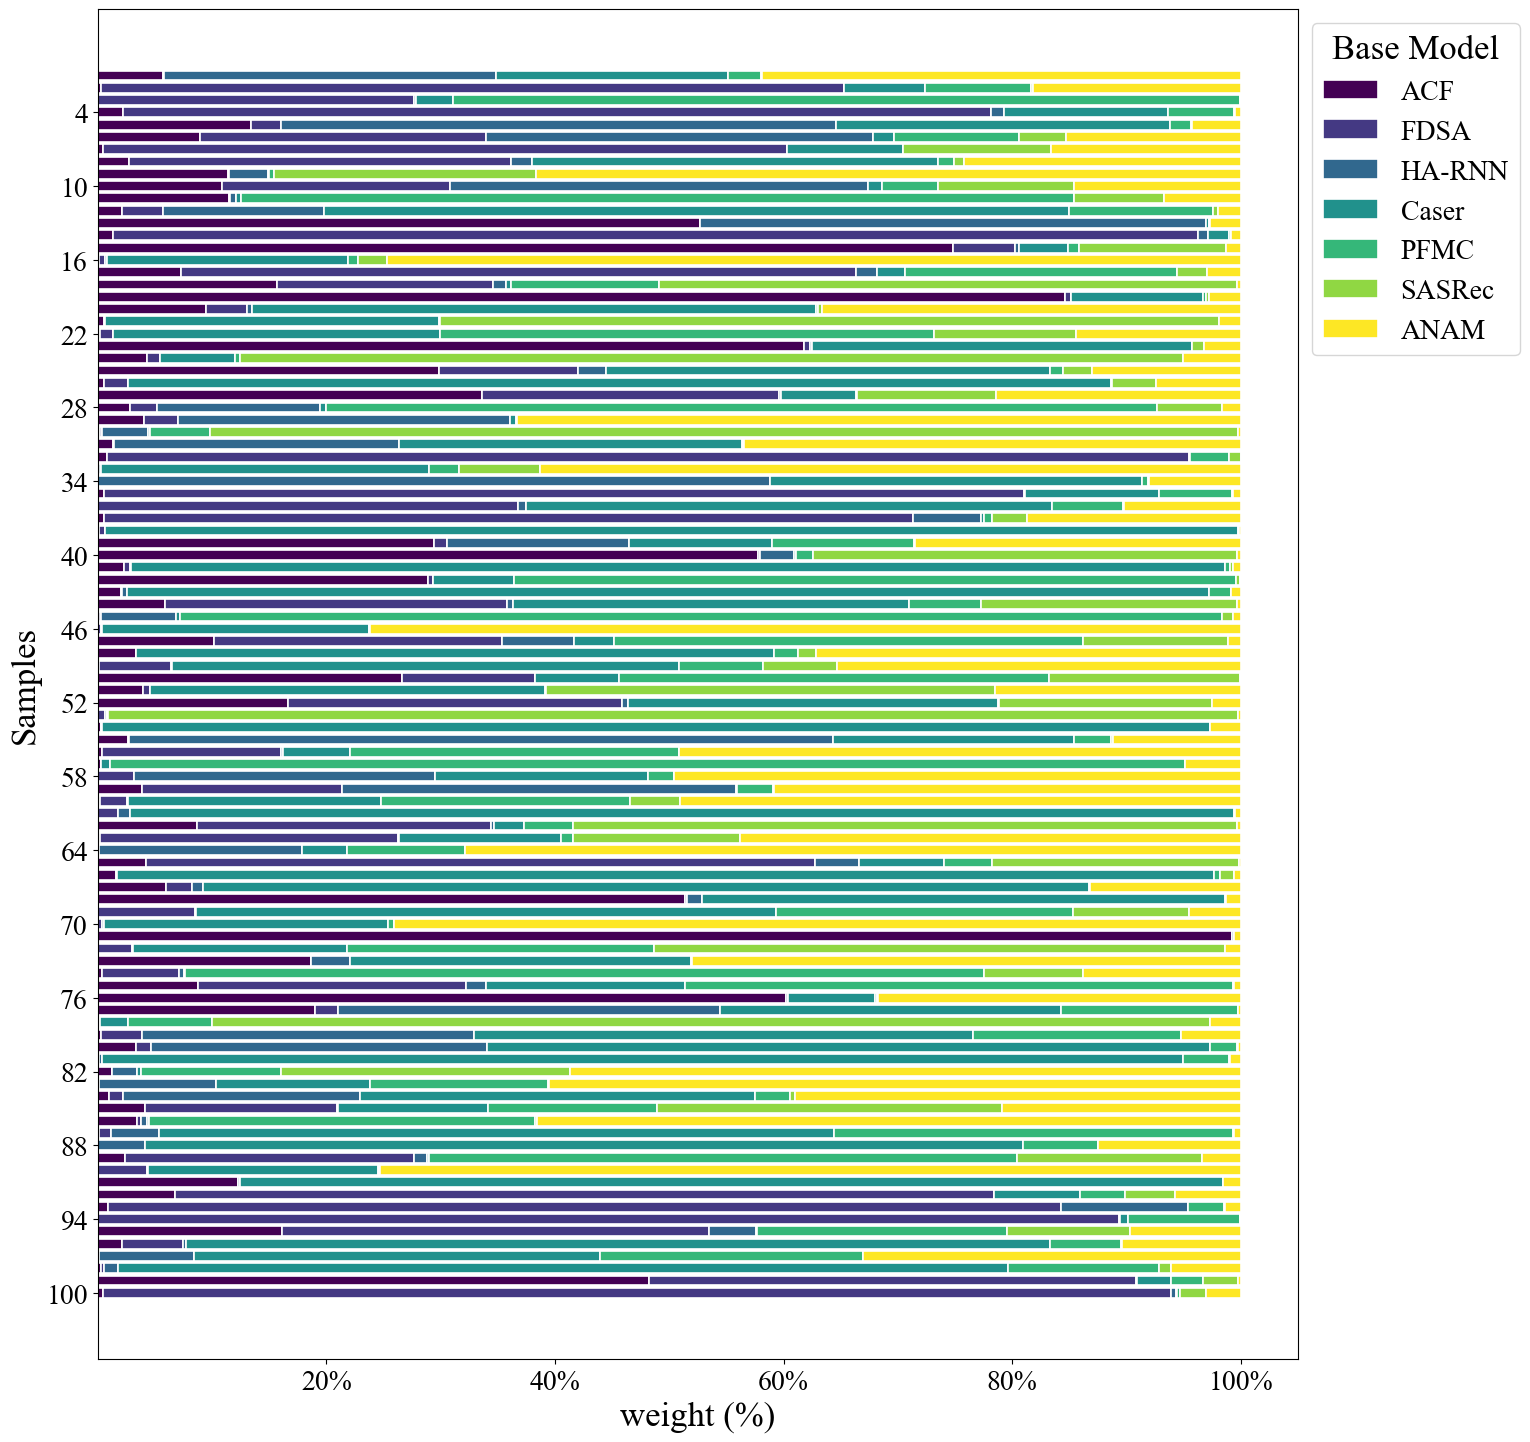

In [ ]:
import numpy as np

# 假设 weights 是你的数据
weights = wgts  # 请替换为实际数据

# 模型名称
models = ['ACF', 'FDSA', 'HA-RNN', 'Caser', 'PFMC', 'SASRec', 'ANAM']

# 时间周期，从上到下索引
categories = [f'{len(weights) - i}' for i in range(len(weights))]

# 将 weights 转换为 NumPy 数组
weights_np = np.array([w.numpy() for w in weights])

# 定义颜色
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# 绘制堆叠条形图
fig, ax = plt.subplots(figsize=(15, 15))  # 减小高度，调整为更合适的比例
y = np.arange(len(categories))  # 纵轴位置
left = np.zeros(len(categories))  # 初始化左侧位置

for i, model in enumerate(models):
    ax.barh(y, weights_np[:, i], left=left, label=model, color=colors[i], edgecolor='white', linewidth=1.2)
    left += weights_np[:, i]  # 更新左侧位置

# 添加标题和标签
ax.set_ylabel('Samples', fontsize=25)
ax.set_xlabel('weight (%)', fontsize=25)

# 设置纵坐标隔 5 个显示一个
ax.set_yticks(y[::6])
ax.set_yticklabels(categories[::6], fontsize=20)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
ax.tick_params(axis='x', labelsize=20)

# 设置图例
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Base Model', title_fontsize=25, fontsize=20)

# 手动调整子图边距，减少上下空白
fig.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.8)  # 调整上下左右边距

# 保存图像，确保去掉多余空白
plt.savefig('output.png', bbox_inches='tight', pad_inches=0.05)  # 减小 pad_inches
plt.show()

## 其他集成方法

### CombSum

In [13]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'].squeeze(0).sum(dim=0, keepdim=True)
    scores, indices = torch.topk(all_scores, 10)

    for i in range(len(batch['user_id'])):
        user_id = batch['user_id'][i].item()
        pos_item = batch['pos_item'][i].item()

        true_item_ids = data.user_interacted_item_ids[user_id]
        true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

        predicted_item_ids = np.array([indices[i].cpu().numpy().tolist()])
        # score = nDCG(np.array(predicted_item_ids), [true_item_ids])
        # score = map(predicted_item_ids[0], true_item_ids)
        score = mrr(predicted_item_ids[0], true_item_ids)
        metrics.append(score)
np.mean(metrics)

计算测试集指标: 100%|██████████| 14904/14904 [00:22<00:00, 666.08it/s]


0.15995455571743816

### CombMNZ

In [16]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'].squeeze(0).sum(dim=0, keepdim=True)
    item_ids_np = batch['base_model_preds'].cpu().numpy().reshape(-1)
    item_indices = torch.tensor(np.array([data.item_to_id[id] for id in item_ids_np]), device="cuda")
    all_item_counts = torch.bincount(item_indices, minlength=data.n_item)
    all_scores = all_scores * all_item_counts.unsqueeze(0)
    scores, indices = torch.topk(all_scores, 10)

    user_id = batch['user_id'].item()
    pos_item = batch['pos_item'].item()

    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_item_ids = np.array([indices[0].cpu().numpy().tolist()])
    score = nDCG(np.array(predicted_item_ids), [true_item_ids])
    # score = map(predicted_item_ids[0], true_item_ids)
    # score = mrr(predicted_item_ids[0], true_item_ids)
    metrics.append(score)
np.mean(metrics)

计算测试集指标: 100%|██████████| 14904/14904 [00:29<00:00, 502.75it/s]


0.22983398313794107

### ​CombANZ

In [53]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'].squeeze(0).sum(dim=0, keepdim=True)
    item_ids_np = batch['base_model_preds'].cpu().numpy().reshape(-1)
    item_indices = torch.tensor(np.array([data.item_to_id[id] for id in item_ids_np]), device="cuda")
    all_item_counts = torch.bincount(item_indices, minlength=data.n_item)
    # 将计数为0的位置替换为无穷大
    all_item_counts[all_item_counts == 0] = 1_000_000_000
    all_scores = all_scores / all_item_counts.unsqueeze(0)
    scores, indices = torch.topk(all_scores, 10)

    user_id = batch['user_id'].item()
    pos_item = batch['pos_item'].item()

    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_item_ids = np.array([indices[0].cpu().numpy().tolist()])
    print(predicted_item_ids.shape)
    score = nDCG(np.array(predicted_item_ids), [true_item_ids])
    # score = map(predicted_item_ids[0], true_item_ids)
    # score = mrr(predicted_item_ids[0], true_item_ids)
    metrics.append(score)
np.mean(metrics)

计算测试集指标:   0%|          | 11/25369 [00:00<04:00, 105.36it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   0%|          | 40/25369 [00:00<03:07, 134.98it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   0%|          | 112/25369 [00:00<01:58, 213.06it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 134/25369 [00:00<02:00, 208.71it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 188/25369 [00:00<01:44, 240.12it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 251/25369 [00:01<01:47, 234.39it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|          | 276/25369 [00:01<01:52, 222.89it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|▏         | 326/25369 [00:01<01:50, 226.40it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   1%|▏         | 376/25369 [00:01<01:46, 234.28it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   2%|▏         | 427/25369 [00:01<01:43, 240.42it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   2%|▏         | 499/25369 [00:02<01:23, 296.28it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


计算测试集指标:   2%|▏         | 566/25369 [00:02<01:45, 235.02it/s]

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


KeyboardInterrupt: 

### 根据基模型加权

In [83]:
ml_wgts = [0.1535, 0.1105, 0.1559, 0.1684, 0.1682, 0.1170, 0.1265]
kuairec_wgts = [0.15, 0.1101, 0.1562, 0.1477, 0.1615, 0.1183, 0.1562]
amazon_wgts = [0.1899, 0.0627, 0.0429, 0.1306, 0.2539, 0.1007, 0.2193]

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
metrics = []
for batch in tqdm(test_loader, desc="计算测试集指标"):
    all_scores = batch['all_item_scores'] * torch.tensor(amazon_wgts, device=batch['all_item_scores'].device).view(1, -1, 1)
    all_scores = all_scores.squeeze(0).sum(dim=0, keepdim=True)
    scores, indices = torch.topk(all_scores, 10)

    user_id = batch['user_id'][0].item()
    pos_item = batch['pos_item'][0].item()

    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_item_ids = np.array([indices[0].cpu().numpy().tolist()])
    score = nDCG(np.array(predicted_item_ids), [true_item_ids])
    # score = map(predicted_item_ids[0], true_item_ids)
    # score = mrr(predicted_item_ids[0], true_item_ids)
    metrics.append(score)
np.mean(metrics)

计算测试集指标:   3%|▎         | 226/8345 [00:00<00:23, 339.11it/s]

### AEM

In [33]:
from model.aem import AEM
aem = AEM(args['model'], args['data'], data.n_user, 10737)
aem.load_state_dict(torch.load("ckpt/kuairec/aem_0.4313.pth"))
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)
infer(aem, 10, 'ndcg')

计算测试集指标: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


np.float64(0.43130702216297756)

### Stack

In [23]:
from model.stack import StackingModel
stack_model = StackingModel(args['model'], args['data'], data.n_user)
stack_model.load_state_dict(torch.load("D:\Code\graduation_design\\bpr\ckpt\kuairec\stack_0.4256.pth"))
stack_model.eval()
infer(stack_model, 10, 'mrr')

计算测试集指标:   0%|          | 0/50 [00:00<?, ?it/s]

计算测试集指标: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


0.3310864184321948

## 基础模型

In [9]:
base_model_results = {}
for base_model in args['data']['base_model']:
    model = np.load(args['data']['base_model_path'] + f"/{base_model}.npy")
    scores = []
    phar = tqdm(test_samples, desc=f"计算{base_model}测试集指标...")
    for case in phar:
        user_id = case['user_id']
        pos_item = case['pos_item']

        interaction_idx = data.get_interaction_index(user_id, data.item_to_id[pos_item])
        assert interaction_idx != -1

        predicted_item_ids = model[interaction_idx][2:2+10]
        true_item_ids = data.user_interacted_item_ids[user_id]
        true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

        predicted_items = np.array([predicted_item_ids])
        # score = nDCG(np.array(predicted_items), [true_item_ids])
        # score = map(predicted_items[0], true_item_ids)
        score = mrr(predicted_items[0], true_item_ids)
        scores.append(score)

        phar.set_postfix(score=score)
    print(f"{base_model}: {round(np.mean(scores), 4)}")

计算acf测试集指标...: 100%|██████████| 24024/24024 [00:28<00:00, 831.93it/s, score=0]    


acf: 0.23418990070775786


计算fdsa测试集指标...: 100%|██████████| 24024/24024 [00:34<00:00, 692.97it/s, score=0]    


fdsa: 0.10429978421049849


计算harnn测试集指标...: 100%|██████████| 24024/24024 [00:27<00:00, 875.79it/s, score=0]    


harnn: 0.1450569106819107


计算caser测试集指标...: 100%|██████████| 24024/24024 [00:29<00:00, 819.38it/s, score=0]    


caser: 0.23844888577031434


计算pfmc测试集指标...: 100%|██████████| 24024/24024 [00:34<00:00, 701.10it/s, score=0]    


pfmc: 0.2854783939605368


计算sasrec测试集指标...: 100%|██████████| 24024/24024 [00:33<00:00, 717.91it/s, score=0]    


sasrec: 0.0939187135615707


计算anam测试集指标...: 100%|██████████| 24024/24024 [00:28<00:00, 833.26it/s, score=0]    

anam: 0.24562339115910545


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)
for metric in ['ndcg', 'map', 'mrr']:
    print(f"{metric}: {infer(ensrec, 10, metric)}")

计算测试集指标: 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


ndcg: 0.26564731282703286


计算测试集指标: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


map: 0.19748149569650228


计算测试集指标: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]

mrr: 0.20382932247867835


In [75]:
base_model_results = {}
model = np.load("D:\Code\graduation_design\\basemodel_results\Toys_and_Games\\anam.npy")
ndcgs = []
maps = []
mrrs = []
phar = tqdm(test_samples, desc=f"计算测试集指标...")
for case in phar:
    user_id = case['user_id']
    pos_item = case['pos_item']

    interaction_idx = data.get_interaction_index(user_id, data.item_to_id[pos_item])
    assert interaction_idx != -1
    predicted_item_ids = model[interaction_idx][2:2+10]
    true_item_ids = data.user_interacted_item_ids[user_id]
    true_item_ids = true_item_ids[true_item_ids.index(data.item_to_id[pos_item]) + 1:]

    predicted_items = np.array([predicted_item_ids])
    ndcgs.append(nDCG(np.array(predicted_items), [true_item_ids]))
    maps.append(map(predicted_items[0], true_item_ids))
    mrrs.append(mrr(predicted_items[0], true_item_ids))

print(f"ndcg: {round(np.mean(ndcgs), 4)} map: {round(np.mean(maps), 4)} mrr: {round(np.mean(mrrs), 4)}")

计算测试集指标...: 100%|██████████| 14904/14904 [00:02<00:00, 6323.74it/s] 


ndcg: 0.2766 map: 0.2088 mrrs: 0.2413


In [82]:
import numpy as np

# 模型分数
scores = {
    "caser": 0.36663333,
    "pfmc": 0.3661,
    "acf": 0.33413333,
    "anam": 0.27546667,
    "fdsa": 0.2405,
    "harnn": 0.33933333,
    "sasrec": 0.25473333
}

# 计算 Softmax 权重
def calculate_softmax_weights(scores):
    values = np.array(list(scores.values()))
    softmax_weights = values / np.sum(values)  # 归一化
    return dict(zip(scores.keys(), softmax_weights))

weights = calculate_softmax_weights(scores)

# 打印结果
for model, weight in weights.items():
    print(f"{model}: {weight:.4f}")

caser: 0.1684
pfmc: 0.1682
acf: 0.1535
anam: 0.1265
fdsa: 0.1105
harnn: 0.1559
sasrec: 0.1170


In [81]:
import numpy as np

"""
||||
|-|-|-|
|0.4378|0.3134|0.3487|
|0.4444|0.3110|0.3429|
|0.4074|0.2849|0.3101|
|0.3210|0.2381|0.2673|
|0.3192|0.1986|0.2037|
|0.4098|0.2890|0.3192|
|0.3405|0.2155|0.2082|
"""

data = np.array([
    [0.4378, 0.3134, 0.3487],
    [0.4444, 0.3110, 0.3429],
    [0.4074, 0.2849, 0.3101],
    [0.3210, 0.2381, 0.2673],
    [0.3192, 0.1986, 0.2037],
    [0.4098, 0.2890, 0.3192],
    [0.3405, 0.2155, 0.2082]
])

# 计算每一行的均值
row_means = np.mean(data, axis=1)

# 打印结果
print(row_means)

[0.36663333 0.3661     0.33413333 0.27546667 0.2405     0.33933333
 0.25473333]
